# Configure Aggregate Module Params

This notebook should be used as a test for ensuring correct aggregate parameters before aggregate processing.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for aggregate module

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

In [2]:
from pathlib import Path
from itertools import product
import random

import yaml
import pandas as pd
import matplotlib.pyplot as plt

from lib.shared.file_utils import get_filename, load_parquet_subset
from lib.aggregate.cell_data_utils import split_cell_data, channel_combo_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames
from lib.aggregate.filter import (
    query_filter,
    perturbation_filter,
    missing_values_filter,
    intensity_filter,
)
from lib.aggregate.align import (
    prepare_alignment_data,
    pca_variance_plot,
    embed_by_pca,
    tvn_on_controls,
)
from lib.aggregate.aggregate import aggregate
from lib.aggregate.eval_aggregate import (
    nas_summary,
    summarize_cell_data,
    plot_feature_distributions,
)
from lib.shared.configuration_utils import CONFIG_FILE_HEADER

random.seed(42)

## <font color='red'>SET PARAMETERS</font>

### Testing on subset of data

- `TEST_PLATE`: Plate used for testing configuration 
- `TEST_WELL_1`: First well identifier used for testing configuration
- `TEST_WELL_2`: Second well identifier used for testing configuration

In [3]:
TEST_PLATE = 2
TEST_WELL_1 = "A1"
TEST_WELL_2 = "A2"

In [4]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_1}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=25000)

merge_final_fp_2 = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL_2}, "merge_final", "parquet")
)
cell_data_2 = load_parquet_subset(merge_final_fp_2, n_rows=25000)

cell_data = pd.concat([cell_data, cell_data_2], ignore_index=True)
cell_data

Reading first 25,000 rows from brieflow_output/merge/parquets/P-2_W-A1__merge_final.parquet
Reading first 25,000 rows from brieflow_output/merge/parquets/P-2_W-A2__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,2,A1,1607,371,1042.522211,1043.001974,82,12812,2668.323171,2794.323171,...,0.124001,0.033794,0.040176,0.049952,0.012108,6,0.651972,38.443652,50.235333,177.376973
1,2,A1,274,251,1042.337979,1040.619338,22,8334,1912.824324,550.770270,...,0.098765,0.038495,0.091019,0.091244,0.038291,4,0.612069,47.316091,54.566903,150.976756
2,2,A1,1249,390,1040.480674,1041.766105,61,10963,3411.732919,1299.180124,...,0.064997,0.098013,0.081969,0.031391,0.012353,5,0.633570,40.372004,49.410940,173.899903
3,2,A1,1608,345,1042.655106,1040.389210,82,12818,2671.200000,3536.771429,...,0.036450,0.039799,0.045240,0.061003,0.025574,3,0.479253,51.771824,64.589262,81.834929
4,2,A1,1462,324,1041.100148,1040.320475,72,15168,3413.927602,3530.900452,...,0.110070,0.023837,0.013991,0.019438,0.018961,6,0.650000,61.020212,63.672722,81.403521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,A2,1719,535,1042.025101,1200.848583,90,17089,2643.727811,2861.621302,...,0.131414,0.109497,0.083658,0.060107,0.009102,7,0.577957,42.056873,55.161514,163.498230
49996,2,A2,218,453,1194.885781,998.883450,18,6390,1219.177778,1279.711111,...,0.167300,0.026583,0.003863,0.018466,0.022685,4,0.584082,57.699474,71.490079,120.362465
49997,2,A2,264,403,1192.711172,991.801090,20,8928,1953.078125,531.750000,...,0.158342,0.064057,0.049264,0.031830,0.063772,5,0.633803,53.338995,55.316759,153.760516
49998,2,A2,124,421,1067.562979,1198.784228,11,14120,2648.126582,1352.139241,...,0.105591,0.011454,0.078266,0.021861,0.032926,7,0.637744,49.929886,59.595696,166.866549


In [5]:
for col in cell_data.columns:
    print(col)

plate
well
tile
cell_0
i_0
j_0
site
cell_1
i_1
j_1
distance
fov_distance_0
fov_distance_1
cell_barcode_0
gene_symbol_0
cell_barcode_1
gene_symbol_1
mapped_single_gene
channels_min
nucleus_i
nucleus_j
nucleus_bounds_0
nucleus_bounds_1
nucleus_bounds_2
nucleus_bounds_3
cell_i
cell_j
cell_bounds_0
cell_bounds_1
cell_bounds_2
cell_bounds_3
cytoplasm_i
cytoplasm_j
cytoplasm_bounds_0
cytoplasm_bounds_1
cytoplasm_bounds_2
cytoplasm_bounds_3
nucleus_Hoescht_int
nucleus_COX4_int
nucleus_AGP_int
nucleus_ConA_int
nucleus_Hoescht_mean
nucleus_COX4_mean
nucleus_AGP_mean
nucleus_ConA_mean
nucleus_Hoescht_std
nucleus_COX4_std
nucleus_AGP_std
nucleus_ConA_std
nucleus_Hoescht_max
nucleus_COX4_max
nucleus_AGP_max
nucleus_ConA_max
nucleus_Hoescht_min
nucleus_COX4_min
nucleus_AGP_min
nucleus_ConA_min
nucleus_Hoescht_int_edge
nucleus_COX4_int_edge
nucleus_AGP_int_edge
nucleus_ConA_int_edge
nucleus_Hoescht_mean_edge
nucleus_COX4_mean_edge
nucleus_AGP_mean_edge
nucleus_ConA_mean_edge
nucleus_Hoescht_std_edge

## <font color='red'>SET PARAMETERS</font>

### Cell Data Metadata

- `METADATA_COLS_FP`: Path to TSV to store metadata cols.
- `METADATA_COLS`: Columns in cell data with metadata (use output above).

In [6]:
METADATA_COLS_FP = "config/cell_data_metadata_cols.tsv"
METADATA_COLS = [
    "plate",
    "well",
    "tile",
    "cell_0",
    "i_0",
    "j_0",
    "site",
    "cell_1",
    "i_1",
    "j_1",
    "distance",
    "fov_distance_0",
    "fov_distance_1",
    "cell_barcode_0",
    "gene_symbol_0",
    "cell_barcode_1",
    "gene_symbol_1",
    "mapped_single_gene",
    "channels_min",
    "nucleus_i",
    "nucleus_j",
    "nucleus_bounds_0",
    "nucleus_bounds_1",
    "nucleus_bounds_2",
    "nucleus_bounds_3",
    "cell_i",
    "cell_j",
    "cell_bounds_0",
    "cell_bounds_1",
    "cell_bounds_2",
    "cell_bounds_3",
    "cytoplasm_i",
    "cytoplasm_j",
    "cytoplasm_bounds_0",
    "cytoplasm_bounds_1",
    "cytoplasm_bounds_2",
    "cytoplasm_bounds_3",
]

In [7]:
pd.Series(METADATA_COLS).to_csv(METADATA_COLS_FP, index=False, header=False, sep="\t")

metadata, features = split_cell_data(cell_data, METADATA_COLS)
print(metadata.shape, features.shape)

(50000, 37) (50000, 1647)


## <font color='red'>SET PARAMETERS</font>

### Split cells into classes

- `CLASSIFIER_PATH`: Path to pickled Python object that can take a cell data dataframe and output cell classes

### Evaluate splitting

- `COLLAPSE_COLS`: Cell data columns to collapse on when creating a summary of cell counts. This will show the number of cells in each cell class for these particular columns. Ex: `["cell_barcode_0", "gene_symbol_0"]`.
- `MONTAGE_CHANNEL`: Channel to use for montage generation. Usually `DAPI`.

**Notes**: 
- We generate cell classes for each of the classes listed in the classifier and an "all" class. So for a classifier that splits by mitotic or interphase the final classes will be `["mitotic", "interphase", "all"]`.
- You must import necessary packages for the classifier in this notebook and add them to `scripts/aggregate/split_datasets.py` as well. Ex `import numpy as np` if the classifier requires `numpy`.

In [8]:
CLASSIFIER_PATH = None
MONTAGE_CHANNEL = None
COLLAPSE_COLS = None

In [9]:
classifier = None

# Classify cells with safety check
if classifier is not None:
    print("Applying cell classification...")
    classified_metadata, classified_features = classifier.classify_cells(metadata, features)
else:
    print("No classifier specified - using all cells as single class")
    classified_metadata, classified_features = metadata, features

# Create config var for cell classes
if 'class' in classified_metadata.columns:
    CELL_CLASSES = list(classified_metadata["class"].unique())
else:
    CELL_CLASSES = []

# Show cell class counts and distribution
if CELL_CLASSES: 
    print("Cell class counts:")
    print(classified_metadata["class"].value_counts())

    print("\nCell class confidences:")
    classified_metadata["confidence"].hist()
else:
    print("No cell classes available")

No classifier specified - using all cells as single class
No cell classes available


In [10]:
cell_classes = ["all"]

# classified_metadata_copy = classified_metadata.copy(deep=True)
# classified_metadata_copy = add_filenames(classified_metadata_copy, ROOT_FP)

# # Create a dictionary of DataFrames for each cell class
# cell_class_dfs = {
#     cell_class: classified_metadata_copy[
#         classified_metadata_copy["class"] == cell_class
#     ]
#     for cell_class in CELL_CLASSES
# }

# # Define sorting directions and titles
# title_templates = {
#     True: "Lowest Confidence {cell_class} Cells - {channel}",
#     False: "Highest Confidence {cell_class} Cells - {channel}",
# }

# # Generate montages dynamically
# montages, titles = [], []
# for cell_class, cell_df in cell_class_dfs.items():
#     for ascending in [True, False]:
#         montage = create_cell_montage(
#             cell_data=cell_df,
#             channels=config["phenotype"]["channel_names"],
#             selection_params={
#                 "method": "sorted",
#                 "sort_by": "confidence",
#                 "ascending": ascending,
#             },
#         )[MONTAGE_CHANNEL]
#         montages.append(montage)
#         titles.append(
#             title_templates[ascending].format(
#                 cell_class=cell_class, channel=MONTAGE_CHANNEL
#             )

#     # Determine figure size dynamically
#     num_rows = len(CELL_CLASSES)
#     fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

#     # Display montages
#     for ax, title, montage in zip(axes.flat, titles, montages):
#         ax.imshow(montage, cmap="gray")
#         ax.set_title(title, fontsize=14)
#         ax.axis("off")

#     print("Montages of cell classes:")
#     plt.tight_layout()
#     plt.show()

#     print("Split cell data summary:")
#     summary_df = summarize_cell_data(classified_metadata, CELL_CLASSES, COLLAPSE_COLS)
#     display(summary_df)


## <font color='red'>SET PARAMETERS</font>

### Aggregate by channel combos

- `CHANNEL_COMBOS`: Combinations of channels to aggregate by. This is a list of lists with channel names, ex `[["DAPI", "CENPA"], ["DAPI", "WGA"]]`.
- `AGGREGATE_COMBO_FP`: Location of aggregate combinations dataframe.
- `TEST_CELL_CLASS`: Cell class to configure aggregate params with. Can be any of the cell classes or `all`.
- `TEST_CHANNEL_COMBO`: Channel combo to configure aggregate params with; must be one of the channel combos. Ex `["DAPI", "CENPA"]`.

In [11]:
CHANNEL_COMBOS = [["Hoescht", "COX4", "AGP", "ConA"]]
AGGREGATE_COMBO_FP = "config/aggregate_combo.tsv"

TEST_CELL_CLASS = "all"
TEST_CHANNEL_COMBO = ["Hoescht", "COX4", "AGP", "ConA"]

In [12]:
# determine cell classes and channel combos
channel_combos = ["_".join(combo) for combo in CHANNEL_COMBOS]

# Load merge wildcard combos
MERGE_COMBO_FP = Path(config["merge"]["merge_combo_fp"])
merge_wildcard_combos = pd.read_csv(MERGE_COMBO_FP, sep="\t")

# Generate aggregate wildcard combos
aggregate_wildcard_combos = pd.DataFrame(
    product(
        merge_wildcard_combos.itertuples(index=False, name=None),
        cell_classes,
        channel_combos,
    ),
    columns=["plate_well", "cell_class", "channel_combo"],
)
aggregate_wildcard_combos[["plate", "well"]] = pd.DataFrame(
    aggregate_wildcard_combos["plate_well"].tolist(),
    index=aggregate_wildcard_combos.index,
)
aggregate_wildcard_combos = aggregate_wildcard_combos.drop(columns="plate_well")

# Save aggregate wildcard combos
aggregate_wildcard_combos.to_csv(AGGREGATE_COMBO_FP, sep="\t", index=False)

print("Aggregate wildcard combos:")
aggregate_wildcard_combos

Aggregate wildcard combos:


,cell_class,channel_combo,plate,well
0,all,Hoescht_COX4_AGP_ConA,1,A3
1,all,Hoescht_COX4_AGP_ConA,1,A2
2,all,Hoescht_COX4_AGP_ConA,1,A1
3,all,Hoescht_COX4_AGP_ConA,2,B2
4,all,Hoescht_COX4_AGP_ConA,1,B1
5,all,Hoescht_COX4_AGP_ConA,1,B2
6,all,Hoescht_COX4_AGP_ConA,2,B3
7,all,Hoescht_COX4_AGP_ConA,2,A3
8,all,Hoescht_COX4_AGP_ConA,2,A2
9,all,Hoescht_COX4_AGP_ConA,2,B1


In [13]:
# subset cell class
if TEST_CELL_CLASS != "all":
    cell_class_mask = classified_metadata["class"] == TEST_CELL_CLASS
    class_metadata = classified_metadata[cell_class_mask]
    class_features = classified_features[cell_class_mask]
else:
    class_metadata = classified_metadata
    class_features = classified_features

# subset features
all_channels = config["phenotype"]["channel_names"]
class_features = channel_combo_subset(class_features, TEST_CHANNEL_COMBO, all_channels)

# copy metadata and features for later eval
dataset_metadata = class_metadata.copy()
dataset_features = class_features.copy()

# preview metadata and features
display(class_metadata)
display(class_features)

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_bounds_0,cell_bounds_1,cell_bounds_2,cell_bounds_3,cytoplasm_i,cytoplasm_j,cytoplasm_bounds_0,cytoplasm_bounds_1,cytoplasm_bounds_2,cytoplasm_bounds_3
0,2,A1,1607,371,1042.522211,1043.001974,82,12812,2668.323171,2794.323171,...,1008,1019,1078,1092,1039.431674,1058.301377,1008,1019,1078,1092
1,2,A1,274,251,1042.337979,1040.619338,22,8334,1912.824324,550.770270,...,1012,1004,1069,1102,1039.944541,1046.545415,1012,1004,1069,1102
2,2,A1,1249,390,1040.480674,1041.766105,61,10963,3411.732919,1299.180124,...,1006,996,1064,1078,1039.179598,1036.231801,1006,996,1064,1078
3,2,A1,1608,345,1042.655106,1040.389210,82,12818,2671.200000,3536.771429,...,1004,1002,1078,1095,1032.315077,1047.244885,1004,1002,1078,1095
4,2,A1,1462,324,1041.100148,1040.320475,72,15168,3413.927602,3530.900452,...,999,997,1078,1076,1038.609742,1036.063830,999,997,1078,1076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,A2,1719,535,1042.025101,1200.848583,90,17089,2643.727811,2861.621302,...,1013,1172,1074,1247,1039.376321,1218.742777,1013,1172,1074,1247
49996,2,A2,218,453,1194.885781,998.883450,18,6390,1219.177778,1279.711111,...,1145,930,1262,1081,1198.175927,1000.592435,1145,930,1262,1081
49997,2,A2,264,403,1192.711172,991.801090,20,8928,1953.078125,531.750000,...,1155,961,1225,1029,1183.737715,999.635749,1155,961,1225,1029
49998,2,A2,124,421,1067.562979,1198.784228,11,14120,2648.126582,1352.139241,...,1036,1160,1123,1235,1076.645276,1200.057874,1036,1160,1123,1235


,nucleus_Hoescht_int,nucleus_COX4_int,nucleus_AGP_int,nucleus_ConA_int,nucleus_Hoescht_mean,nucleus_COX4_mean,nucleus_AGP_mean,nucleus_ConA_mean,nucleus_Hoescht_std,nucleus_COX4_std,...,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,9062847,5038636,11053409,8566383,8946.541955,4973.974334,10911.558736,8456.449161,1870.529278,1812.223971,...,0.124001,0.033794,0.040176,0.049952,0.012108,6,0.651972,38.443652,50.235333,177.376973
1,9124668,3719663,9940594,6757234,7948.317073,3240.124564,8659.054007,5886.092334,1653.253254,1681.126843,...,0.098765,0.038495,0.091019,0.091244,0.038291,4,0.612069,47.316091,54.566903,150.976756
2,9543459,6494970,13569596,13292025,9458.333994,6437.036670,13448.558969,13173.463826,1672.635237,1934.838692,...,0.064997,0.098013,0.081969,0.031391,0.012353,5,0.633570,40.372004,49.410940,173.899903
3,8879371,4346579,8180355,5795021,8554.307322,4187.455684,7880.881503,5582.871869,1485.562841,2077.471097,...,0.036450,0.039799,0.045240,0.061003,0.025574,3,0.479253,51.771824,64.589262,81.834929
4,20368180,4431227,12596784,7333605,15109.925816,3287.260386,9344.795252,5440.359792,2714.124373,1363.827330,...,0.110070,0.023837,0.013991,0.019438,0.018961,6,0.650000,61.020212,63.672722,81.403521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,14963109,4872620,8495188,6197463,12115.877733,3945.441296,6878.694737,5018.188664,2450.715980,1568.155258,...,0.131414,0.109497,0.083658,0.060107,0.009102,7,0.577957,42.056873,55.161514,163.498230
49996,9197578,5226389,16926802,13722321,5359.893939,3045.681235,9864.103730,7996.690559,965.745507,2066.396516,...,0.167300,0.026583,0.003863,0.018466,0.022685,4,0.584082,57.699474,71.490079,120.362465
49997,9280282,4901063,9004959,8196097,8428.957312,4451.465032,8178.891008,7444.229791,2041.003806,1788.757280,...,0.158342,0.064057,0.049264,0.031830,0.063772,5,0.633803,53.338995,55.316759,153.760516
49998,8822532,3231974,6919982,4938228,9663.233297,3539.949617,7579.388828,5408.792990,2252.773294,1897.776373,...,0.105591,0.011454,0.078266,0.021861,0.032926,7,0.637744,49.929886,59.595696,166.866549


## <font color='red'>SET PARAMETERS</font>

### Perturbation filtering

- `FILTER_QUERIES`: Queries to use for custom filtering; ex: `["mapped_single_gene == True", "cell_quality_score > 0.8"]`. Can be left as `None` for no filtering.
- `PERTURBATION_NAME_COL`: Name of column used to identify perturbations. This is the column that aggregation takes place on. Ex "gene_symbol_0".

In [14]:
FILTER_QUERIES = ["mapped_single_gene == True"]
PERTURBATION_NAME_COL = "gene_symbol_0"

Query 'mapped_single_gene == True' filtered out 25786 cells
Found 24214 cells with assigned perturbations
Unique populations: 10500
                           column  percent_na
0   cytoplasm_Hoescht_mean_frac_0    0.715908
1      cytoplasm_COX4_mean_frac_0    0.715908
2       cytoplasm_AGP_mean_frac_0    0.715908
3      cytoplasm_ConA_mean_frac_0    0.715908
12  cytoplasm_Hoescht_radial_cv_0    0.715908
13     cytoplasm_COX4_radial_cv_0    0.715908
14      cytoplasm_AGP_radial_cv_0    0.715908
15     cytoplasm_ConA_radial_cv_0    0.715908


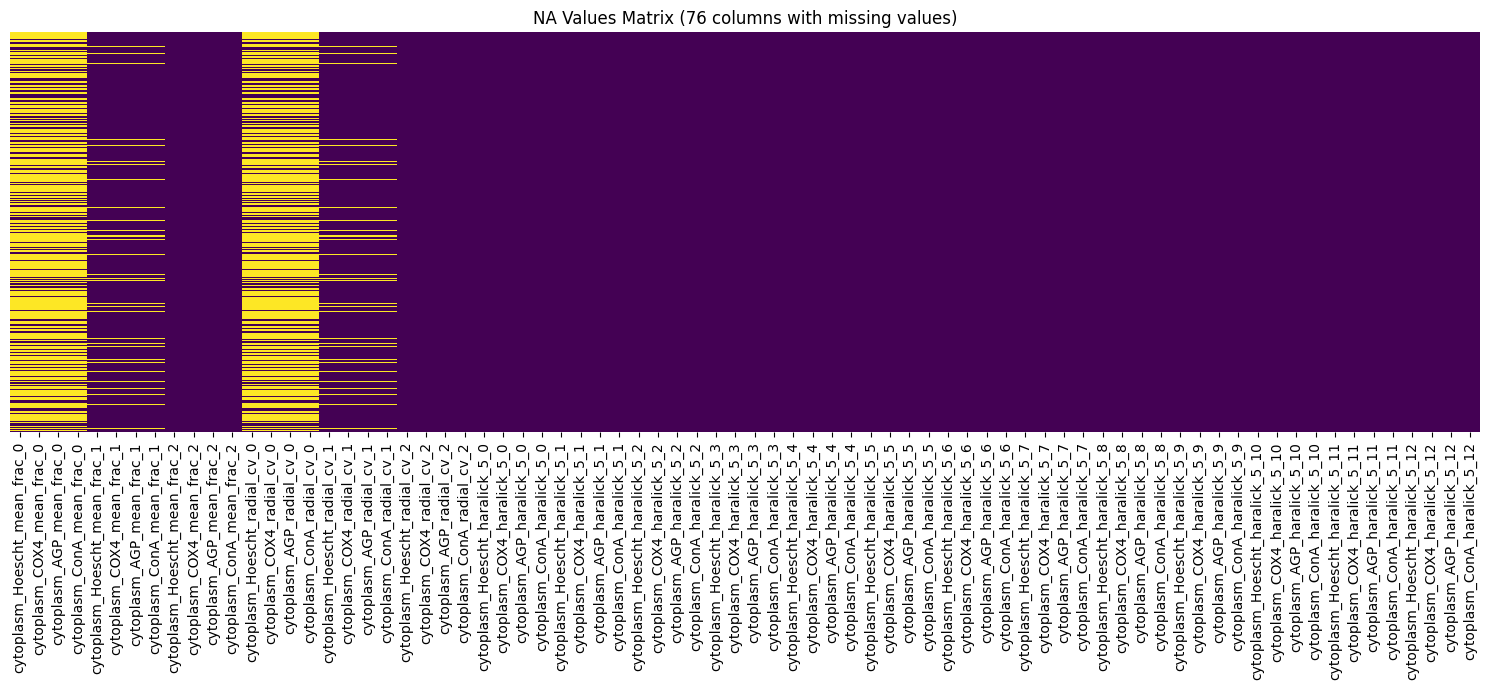

In [15]:
qf_metadata, qf_features = query_filter(class_metadata, class_features, FILTER_QUERIES)

pf_metadata, pf_features = perturbation_filter(
    qf_metadata, qf_features, PERTURBATION_NAME_COL
)
print(f"Unique populations: {metadata[PERTURBATION_NAME_COL].nunique()}")

summary_df, fig = nas_summary(pf_features)
print(summary_df[summary_df["percent_na"] > 0.1])
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Missing value filtering

- `DROP_COLS_THRESHOLD`: Threshold of NA values above which an entire column is dropped. Usually `0.1`
- `DROP_ROWS_THRESHOLD`: Threshold of NA values above which an entire row is dropped. Usually `0.01`
- `IMPUTE`: Whether or not to impute remaining missing values. Usually `True`

**Note**: All NAs must be dropped or imputed to perform feature alignment.

In [16]:
DROP_COLS_THRESHOLD = 0.01
DROP_ROWS_THRESHOLD = 0.01
IMPUTE = True

In [17]:
# Filter by missing values
mvf_metadata, mvf_features = missing_values_filter(
    pf_metadata,
    pf_features,
    drop_cols_threshold=DROP_COLS_THRESHOLD,
    drop_rows_threshold=DROP_ROWS_THRESHOLD,
    impute=True,
)

mvf_metadata.shape, mvf_features.shape

Dropping 16 columns with ≥1.0% missing values
Dropped 2 rows with ≥1.0% missing values
Imputing 8 columns with remaining missing values using batched KNN
Imputing for batch 1 with 5 NA rows


/mnt/data/blainey/whitney-analysis/brieflow/workflow/lib/aggregate/filter.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col] = features[col].astype(dtype)


((24212, 37), (24212, 1631))

## <font color='red'>SET PARAMETERS</font>

### Intensity filtering

- `CONTAMINATION`: Expected proportion of outliers in dataset. Usually `0.01`

In [18]:
CONTAMINATION = 0.01

In [19]:
# Filter by intensity outliers
if_metadata, if_features = intensity_filter(
    mvf_metadata,
    mvf_features,
    config["phenotype"]["channel_names"],
    CONTAMINATION,
)

if_metadata.shape, if_features.shape

((23969, 37), (23969, 1631))

## <font color='red'>SET PARAMETERS</font>

### Perturbation Score Filtering

One can optionally assigned perturbation scores to each cell with perturbation scoring and filtering. During scoring, we train a Logistic Regression classifier on perturbed and control cell features. The result of this training and classification process is:
- `AUC Score` assinged per perturbation: this represents the classifier's ability to distinguish between perturbed and control cells -> higher AUC score, more clear effect on perturbation level
- `Perturbation Probability` assigned per cell: this represents the classifier's assigned probability of the cell being perturbed -> higher perturbation probability, more clear effect on cell level

Once perturbation scores are assigned, one can optionally filter with a probability or percentile threshold before aggregation. Control cells will not be filtered.

Configure perturbation score filtering with:
- `SKIP_PERTURBATION_SCORE`: Whether or not to skip perturbation scoring entirely. Usually `False`
- `PS_PROBABILITY_THRESHOLD`: Probability threshold above which to keep perturbed cells. Usually `0.75`
- `PS_PERCENTILE_THRESHOLD`: Percentile threshold above which to keep perturbed cells. Usually `0.75`

Leave `PS_PROBABILITY_THRESHOLD` and `PS_PERCENTILE_THRESHOLD` as `None` if no filtering is desired.

**Notes:** 
- We don't test perturbation scoring within this notebook as it requires sampling many cells with the same perturbation across plates and wells
- Both types of threshold will remove cells, and probability threshold can potentially eliminate all cells in a perturbation
- Perturbation scoring can take hours per dataset

In [20]:
SKIP_PERTURBATION_SCORE = True
PS_PROBABILITY_THRESHOLD = None
PS_PERCENTILE_THRESHOLD = None

## <font color='red'>SET PARAMETERS</font>

### Prepare alignment data

- `BATCH_COLS`: Which columns of metadata have batch-specific information. Usually `["plate", "well"]`.
- `CONTROL_KEY`: Name of perturbation in `PERTURBATION_NAME_COL` that indicates a control cell.
- `PERTURBATION_ID_COL`: Name of column that identifies unique perturbations. Only needed if you want your controls to have different perturbation names, ex `cell_barcode_0`. Otherwise, can leave this as `None`.

In [21]:
BATCH_COLS = ["plate", "well"]
CONTROL_KEY = "nontargeting_intergenic_"
PERTURBATION_ID_COL = "cell_barcode_0"

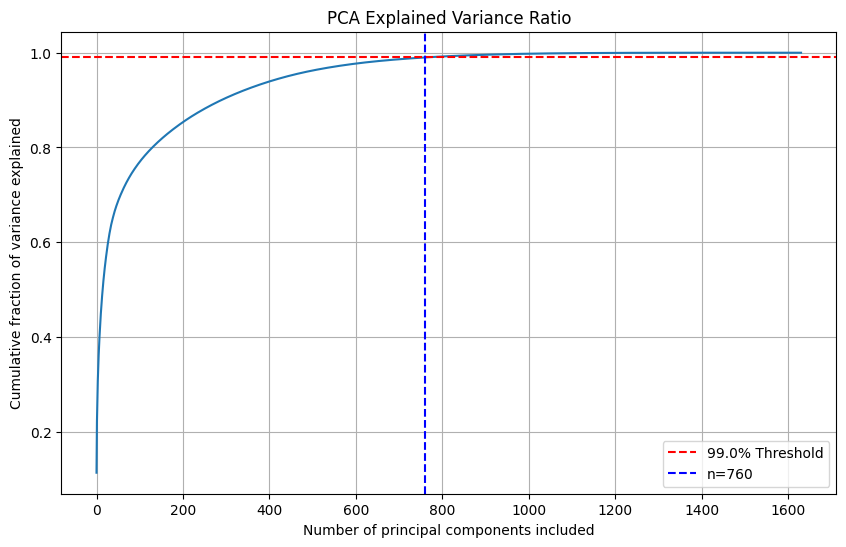

In [22]:
pad_metadata, pad_features = prepare_alignment_data(
    if_metadata,
    if_features,
    BATCH_COLS,
    PERTURBATION_NAME_COL,
    CONTROL_KEY,
    PERTURBATION_ID_COL,
)

n_components, fig = pca_variance_plot(pad_features, variance_threshold=0.99)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Align and aggregate

- `VARIANCE_OR_NCOMP`: Variance or number of components to keep after PCA.
- `NUM_ALIGN_BATCHES`: Number of batches to use when aligning, usually `1`. Increase this if you are running out of memory while aligning. We were able to barely fit 8 plates with 6 wells each in 1 TB of memory with `NUM_ALIGN_BATCHES=1`.
- `AGG_METHOD`: Method used to aggregate features. Can be `mean` or `median`. Usually `median`.

While we use a simplified aggregate method in the notebook, the way this works during a normal run is:
1) Take a subset of 1,000,000 cells, or the entire dataset, whichever is smaller and compute a PCA transform with `VARIANCE_OR_NCOMP`.
2) Subset the entire dataset `NUM_BATCHES` number of times and align cells in this batch.
3) Aggregate across all aligned cell data.

In [23]:
VARIANCE_OR_NCOMP = 0.99
NUM_ALIGN_BATCHES = 1
AGG_METHOD = "median"

In [24]:
pca_embeddings = embed_by_pca(
    pad_features,
    pad_metadata,
    variance_or_ncomp=VARIANCE_OR_NCOMP,
    batch_col="batch_values",
)

tvn_normalized = tvn_on_controls(
    pca_embeddings, pad_metadata, PERTURBATION_NAME_COL, CONTROL_KEY, "batch_values"
)

aggregated_embeddings, aggregated_metadata = aggregate(
    tvn_normalized, pad_metadata, PERTURBATION_NAME_COL, AGG_METHOD
)

feature_columns = [f"PC_{i}" for i in range(tvn_normalized.shape[1])]

tvn_normalized_df = pd.DataFrame(
    tvn_normalized, index=pad_metadata.index, columns=feature_columns
)
aligned_cell_data = pd.concat([pad_metadata, tvn_normalized_df], axis=1)

aggregated_embeddings_df = pd.DataFrame(
    aggregated_embeddings, index=aggregated_metadata.index, columns=feature_columns
)
aggregated_cell_data = (
    pd.concat([aggregated_metadata, aggregated_embeddings_df], axis=1)
    .sort_values("cell_count", ascending=False)
    .reset_index(drop=True)
)

/mnt/data/blainey/whitney-analysis/brieflow/workflow/lib/aggregate/align.py:174: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/mnt/data/blainey/whitney-analysis/brieflow/workflow/lib/aggregate/align.py:179: ComplexWarning: Casting complex values to real discards the imaginary part
  embeddings[batch_ind] = np.matmul(
/mnt/data/blainey/whitney-analysis/brieflow/workflow/lib/aggregate/align.py:174: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  batch_ind & (metadata[pert_col].str.startswith(control_key)).to_list()
/mnt/data/blainey/whitney-analy

/mnt/data/blainey/whitney-analysis/brieflow/workflow/lib/aggregate/eval_aggregate.py:130: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_orig = df_orig.groupby(["Feature", "plate_well"], group_keys=False).apply(
/mnt/data/blainey/whitney-analysis/brieflow/workflow/lib/aggregate/eval_aggregate.py:136: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_aligned = df_aligned.groupby(["Feature", "plate_well"], group_keys=

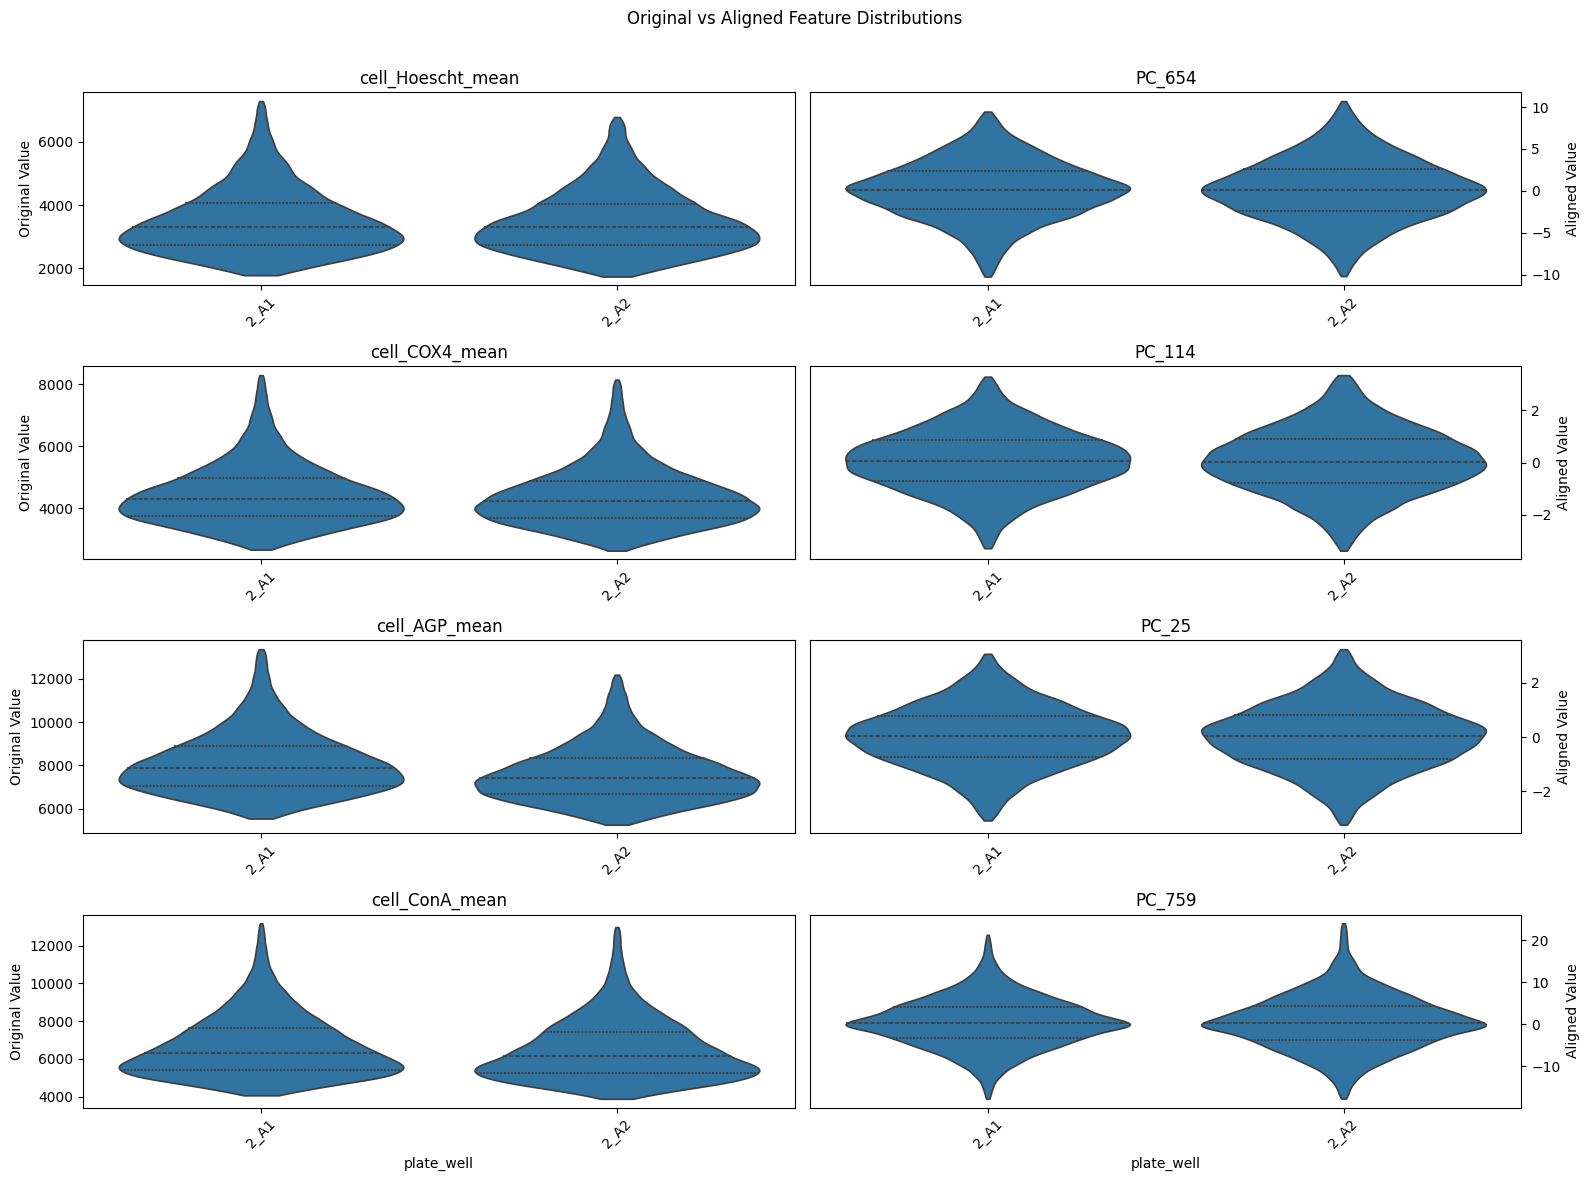

In [25]:
original_feature_cols = [
    col
    for col in dataset_features.columns
    if ("cell_" in col and col.endswith("_mean"))
]
pc_cols = [col for col in aggregated_cell_data.columns if col.startswith("PC_")]
aligned_feature_cols = random.sample(
    pc_cols, k=min(len(original_feature_cols), len(pc_cols))
)

original_cell_data = pd.concat([dataset_metadata, dataset_features], axis=1)
original_cell_data

feature_distributions_fig = plot_feature_distributions(
    original_feature_cols,
    original_cell_data,
    aligned_feature_cols,
    aligned_cell_data,
)
plt.show()

## <font color='red'>SET PARAMETERS</font>
### Generate feature table & bootstrapping

Bootstrapping is a statistical resampling method used to determine if perturbations (gene knockdowns, drug treatments, etc.) cause statistically significant changes compared to controls. The method works by:
1. Taking your control population and repeatedly resampling it to create thousands of "null" distributions
2. Comparing each perturbation's effect size against these null distributions
3. Calculating p-values based on how often the null distributions produce effects as large as the real perturbation

- `FEATURE_NORMALIZATION`: Method for normalizing features before bootstrapping. Options: `"standard"` (standard scalar) or `"mad"` (median absolute deviation).
- `NUM_SIMS`: Number of bootstrap simulations to run for statistical testing. Ex: `100000`.
- `EXCLUSION_STRING`: String to exclude certain constructs from analysis (optional). Ex: `"nontargeting_noncutting_"` or `None`.
- `BOOTSTRAP_CELL_CLASS`: Cell class to run bootstrapping on. Ex: `"Interphase"` or `"all"`.
- `BOOTSTRAP_CHANNEL_COMBO`: Channel combination to run bootstrapping on. Ex: `"DAPI_Ki-67_COXIV_Caspase-3_WGA_aTubulin_Vimentin_gH2AX_Phalloidin"`.
- `PSEUDOGENE_PATTERNS`: Dictionary defining how to group single-construct genes into pseudo-genes for more robust statistical testing. For each pattern category, specify:
  - `pattern`: Regex pattern to match gene names
  - `constructs_per_pseudogene`: Number of constructs to group together

**Note**: Without the combinations configured, bootstrapping will be skipped entirely. Bootstrap analysis can take hours to days depending on `NUM_SIMS` and dataset size.

In [ ]:
FEATURE_NORMALIZATION = "mad"
NUM_SIMS = 10000
EXCLUSION_STRING = None
BOOTSTRAP_CELL_CLASS = "all"
BOOTSTRAP_CHANNEL_COMBO = "Hoescht_COX4_AGP_ConA"
PSEUDOGENE_PATTERNS = {
    "nontargeting_noncutting": {
        "pattern": r"^nontargeting_noncutting_",
        "constructs_per_pseudogene": 2
    },
    "nontargeting_intergenic": {
        "pattern": r"^nontargeting_intergenic_", 
        "constructs_per_pseudogene": 2
    },
    "olfactory_receptors": {
        "pattern": r"^nontargeting_or_",
        "constructs_per_pseudogene": 2
    }
}

## Add aggregate parameters to config file

In [27]:
# Add aggregate section
config["aggregate"] = {
    "metadata_cols_fp": METADATA_COLS_FP,
    "collapse_cols": COLLAPSE_COLS,
    "classifier_path": CLASSIFIER_PATH,
    "aggregate_combo_fp": AGGREGATE_COMBO_FP,
    "filter_queries": FILTER_QUERIES,
    "perturbation_name_col": PERTURBATION_NAME_COL,
    "drop_cols_threshold": DROP_COLS_THRESHOLD,
    "drop_rows_threshold": DROP_ROWS_THRESHOLD,
    "impute": IMPUTE,
    "contamination": CONTAMINATION,
    "batch_cols": BATCH_COLS,
    "control_key": CONTROL_KEY,
    "perturbation_id_col": PERTURBATION_ID_COL,
    "variance_or_ncomp": VARIANCE_OR_NCOMP,
    "num_align_batches": NUM_ALIGN_BATCHES,
    "agg_method": AGG_METHOD,
    "skip_perturbation_score": SKIP_PERTURBATION_SCORE,
    "ps_probability_threshold": PS_PROBABILITY_THRESHOLD,
    "ps_percentile_threshold": PS_PERCENTILE_THRESHOLD,
}

if BOOTSTRAP_CELL_CLASS and BOOTSTRAP_CHANNEL_COMBO:
    BOOTSTRAP_COMBINATIONS = [{
        "cell_class": BOOTSTRAP_CELL_CLASS,
        "channel_combo": BOOTSTRAP_CHANNEL_COMBO
    }]
    config["aggregate"].update({
        "feature_normalization": FEATURE_NORMALIZATION,
        "num_sims": NUM_SIMS,
        "exclusion_string": EXCLUSION_STRING,
        "bootstrap_combinations": BOOTSTRAP_COMBINATIONS,
        "pseudogene_patterns": PSEUDOGENE_PATTERNS,
    })

# Write the updated configuration
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)